<a href="https://colab.research.google.com/github/bgalerne/IoT_data_science/blob/main/Maximum_entropy_model_for_CNN_texture_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Maximum entropy methods for texture synthesis: theor y and practice, V. De Bor toli, A. Desolneux, A. Dur mus, B. Galer ne, A. Leclaire, SIAM Jour nal on Mathematics of Data Science (SIMODS), 2021

See slide : https://www.idpoisson.fr/galerne/mva/cours8_exponential_models.pdf



In [4]:
import numpy as np
import matplotlib.pyplot as plt

import skimage
import skimage.color

import imageio

from IPython.display import display
from PIL import Image
import os


**ADSN initialization:** 

Let $h\in\mathbb{R}^{M\times N}$ be a an image, $m$ be the mean of $h$ and $X$ be a Gaussian white noise image.
The random image
$$
\frac{1}{\sqrt{MN}}\left(h - m\right) \ast X
$$
is the ADSN associated with $h$.

This generalizes to **RGB color images** by
$$
Y = \frac{1}{\sqrt{MN}}
\begin{pmatrix}
\left( h_r - m_r \right) \ast X\\
\left( h_g - m_g \right) \ast X\\
\left( h_b - m_b \right) \ast X
\end{pmatrix},~~~X~\text{a Gaussian white noise.}
$$


**Functions**

$V(x, \Theta) = \Theta · (f(x) − f(x0)) + J(x)$

Where:

* $x0$ is the target texture, 

* $f(x)$ the spatial average of the feature responses of each selected layer

* $J(x) = \frac{\epsilon}{2}  \left\| x \right\|^2$


**SOUL algorithm**

* Initialization: $\theta \leftarrow 0$; $X_0^0 \in \mathbb{R}^d$
* For $n = 1, \ldots, N$,

  * $m_n$ steps of Langevin diffusion: for $k=0,\ldots,m_n-1$, 
         
  $$
  X_{k+1}^n = X_k^n - \gamma_{n+1} \nabla_x V(X_k^n,\theta_n) + \sqrt{2\gamma_{n+1}} Z_{k+1}^n
  $$
  with $Z_{k+1}^n \sim \mathcal{N}(0,I)$

 * Update $\theta$ with Langevin intermediary states:

  $$
  \theta_{n+1} = \mathsf{Proj}_{\Theta}\left( \theta_n + \frac{\delta_{n+1}}{m_n} \sum_{k=1}^{m_n} \nabla_{\theta}V(X_k^n,\theta_n) \right)
  $$

 * Set warm start for next step: $X_0^{n+1} = X_{m_n}^n$


**On Practice:**

* We not do projections.
* $\epsilon = 0.1$ 
* $\gamma$ and $\delta$ are fixed.
* $m = 1$, so we do one update of $\Theta$, one update of $x$ and so on. 
* use the layers [1, 3, 6, 8, 11, 13, 15, 24, 26, 31] for optimization.

## Importing Packages ##

Below is a list of the packages needed to implement the texture synthesis.



* `torch` (indispensables packages for neural networks with PyTorch)
* `torchvision.transforms.functional` (necessary to transform images into tensors)
* `torchvision.models` (for get vgg network)
* `torch.optim` (efficient gradient descents)
* `PIL.Image, matplotlib.pyplot, os` (load and display images)

In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.functional import mse_loss
import torchvision.models as models
from torchvision.transforms.functional import resize, to_tensor, normalize, to_pil_image

from PIL import Image
import matplotlib.pyplot as plt
import os
import math

## Loading Images

On next section we will load images. Here we will just get, display and save the image, without doing any changes to it. 

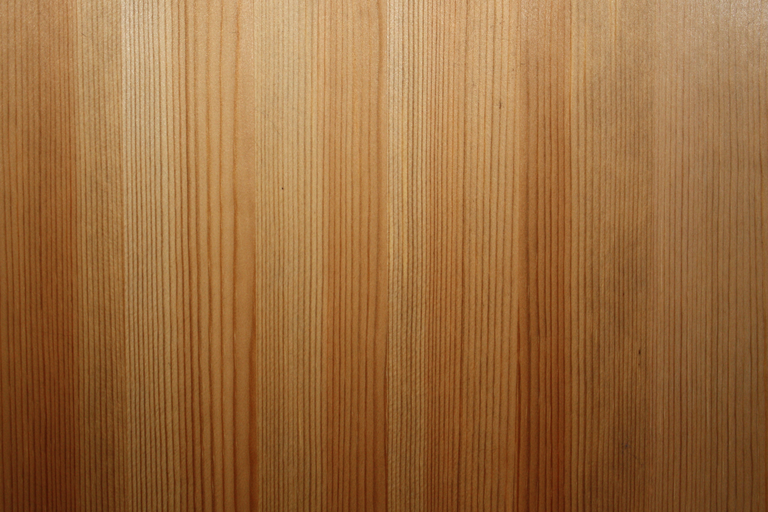

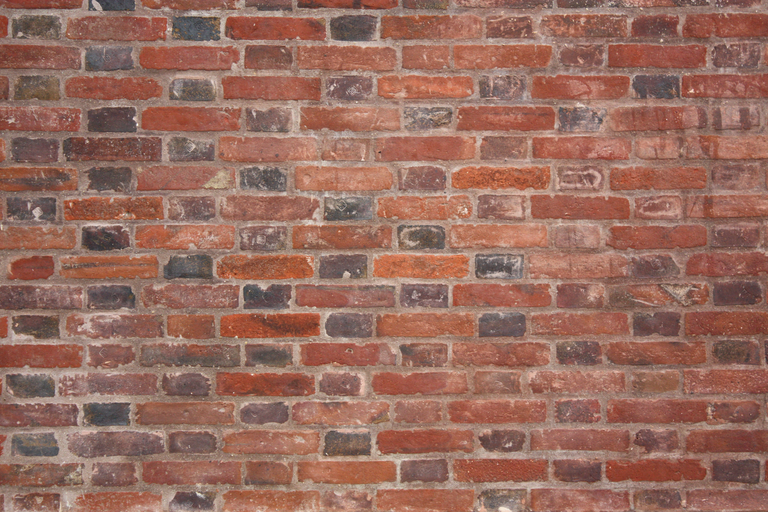

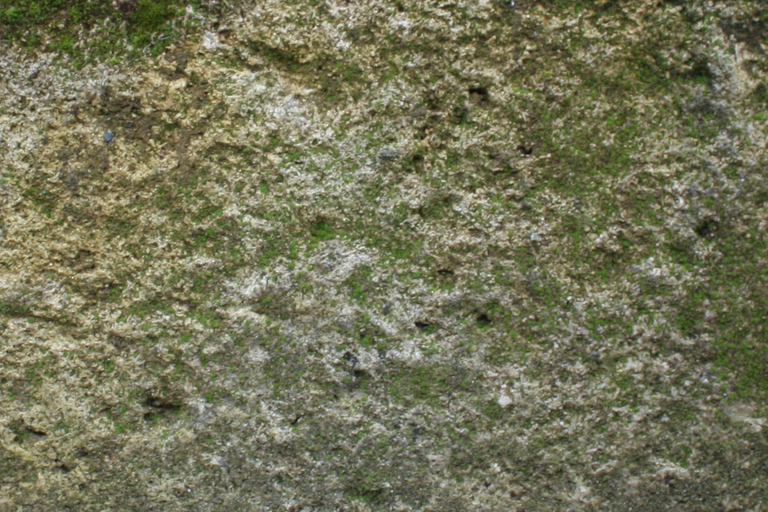

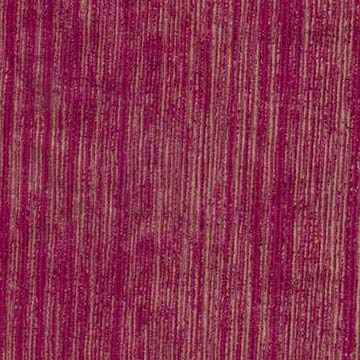

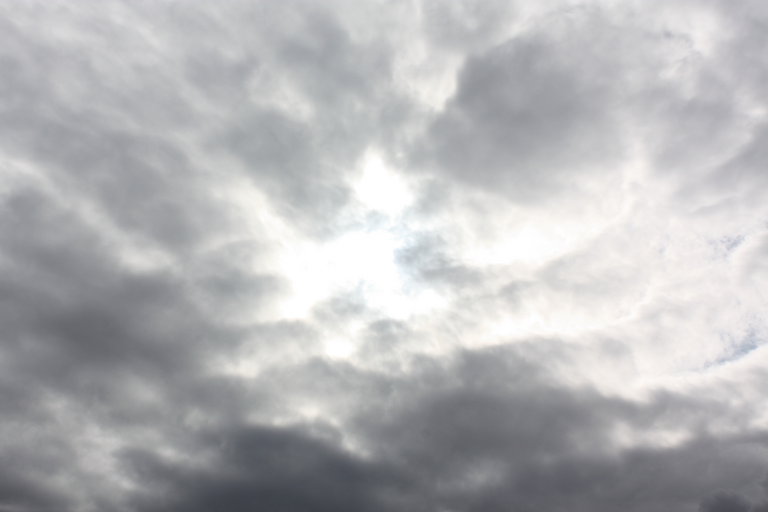

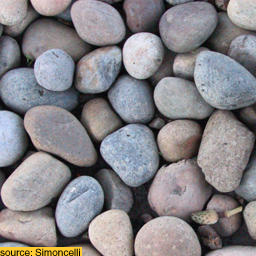

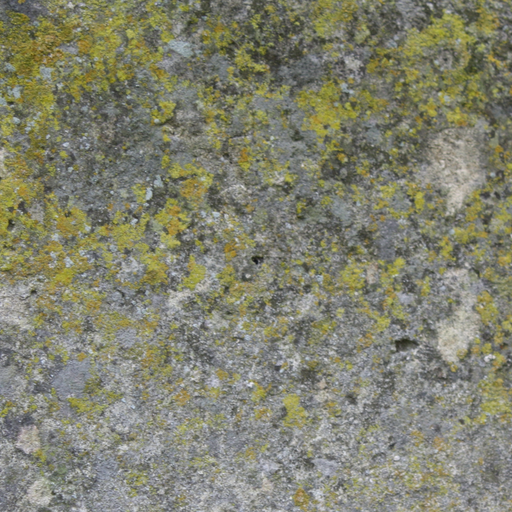

In [6]:
texture_imgnames = ["bois.png", "briques.png", "mur.png", "tissu.png", "nuages.png","pebbles.jpg","wall1003.png"]

for fname in texture_imgnames:
    os.system("wget -c https://www.idpoisson.fr/galerne/mva/"+fname)
    img = Image.open(fname)
    display(img)

## Set a device

Next, we need to choose which device to run the network. Running the algorithm on large images takes longer and will go much faster when running on a GPU. We can use `torch.cuda.is_available()` to detect if there is a GPU available. Next, we set the `torch.device`. Also the `.to(device)` method is used to move tensors or modules to a desired device.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
!nvidia-smi

Device is cuda
Thu Jan 27 17:00:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                         

## Prepare data ##

The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. 

An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. Additionally, VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] (mean and standard deviation of Imagenet). We will have to normalize the image tensor before sending it into the network.

Here some auxiliary functions to load, display and transform to tensors. 

In [8]:
# Utilities
# Functions to manage images

MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

def convert_img(image: str, size=None):
    """Preprocess image with no normalization.
    1) convert to tensor
    2) remove alpha channel if any
    """
    im = Image.open(image)
    texture = resize(im, size)
    texture_tensor = to_tensor(texture).unsqueeze(0)
    if texture_tensor.shape[1]==4:
        print('removing alpha chanel')
        texture_tensor = texture_tensor[:,:3,:,:]
    return texture_tensor


def prep_img(image: str, size=None, mean=MEAN, std=STD):
    """Preprocess image.
    1) load as PIl
    2) resize
    3) convert to tensor
    5) remove alpha channel if any
    4) normalize
    """
    im = Image.open(image)
    texture = resize(im, size)
    texture_tensor = to_tensor(texture).unsqueeze(0)
    if texture_tensor.shape[1]==4:
        print('removing alpha chanel')
        texture_tensor = texture_tensor[:,:3,:,:]
    texture_tensor = normalize(texture_tensor, mean=mean, std=std)
    return texture_tensor


def denormalize(tensor: torch.Tensor, mean=MEAN, std=STD, inplace: bool = False):
    """Based on torchvision.transforms.functional.normalize.
    """
    tensor = tensor.clone().squeeze() 
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor


def to_pil(tensor: torch.Tensor):
    """Converts tensor to PIL Image.
    Args: tensor (torch.Temsor): input tensor to be converted to PIL Image of torch.Size([C, H, W]).
    Returns: PIL Image: converted img.
    """
    img = tensor.clone().detach().cpu()
    img = denormalize(img).clip(0, 1)
    img = to_pil_image(img)
    return img

def to_pil_no_denormalizing(tensor: torch.Tensor):
    """Converts tensor to PIL Image with no denormailzing.
    Args: tensor (torch.Temsor): input tensor to be converted to PIL Image of torch.Size([C, H, W]).
    Returns: PIL Image: converted img.
    """
    img = tensor.clone().detach().cpu()
    img = img.squeeze() #.clip(0, 1)
    img = to_pil_image(img)
    return img

Now, we transform the image to tensor, making the normalization and resize.

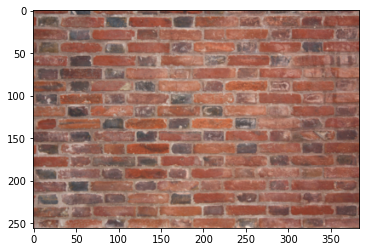

In [40]:
input_image_name = "briques.png"
img_size = 256

# Prepare texture data
target = prep_img(input_image_name, img_size).to(device)

# Display it
plt.imshow(to_pil(target))

## Model

Now we need to import a pretrained neural network. We will use as base the 19 layer VGG network of PyTorch.

PyTorch implementation of VGG is a module divided into two child Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers). For the texture synthesis task we only care about the layers of the features module. 

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

We will change The network so it result differentiable. We will change Relu for CeLu and Max Pooling for Average Pooling.

Also, don't let the parameters change (the network is already trained). 

On the output of next commands you can see the structure of `features` module. Indexes will help to select the needed layers for the algorithm. 

In [11]:
def differentiable(cnn):
    """
    This function replaces non differentiable non-linear functions
    in the network by differentiable ones.
    """

    for i, layer in cnn.named_modules():
        if isinstance(layer, nn.ReLU):
            cnn[int(i)] = nn.CELU(inplace=True)
        if isinstance(layer, nn.MaxPool2d):
            cnn[int(i)] = nn.AvgPool2d(2, stride=2, padding=0, ceil_mode=False)

# Replace no differentiable functions
differentiable(cnn)

# Don't let parameters to change
cnn.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): CELU(alpha=1.0, inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): CELU(alpha=1.0, inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): CELU(alpha=1.0, inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): CELU(alpha=1.0, inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): CELU(alpha=1.0, inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): CELU(alpha=1.0, inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): CELU(alpha=1.0, inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): CELU(alpha=1.0

According to the algorithm explained at the beginning of this notebook, we need to access the outputs of some selected intermediate layers.

In order to access the outputs of the layers on PyTorch VGG19 network, we need to register a hook on each layer we need. Hooks are functions, able to be attached to every layer and called each time the layer is used. You can register a hook before or after the forward pass, or after the backward pass. We will define a function `save_output` that will be triggered after the forward pass, for each layer of `features` module. 

The outputs of the layers will be store on a dictionary where the key is the index of the layer and the value is the output tensor of the layer.

So, we must define which layers will be part of the optimization. Using the indexes of layers, we select the layers to use in the algorithm. We will choose indexes [1, 3, 6, 8, 11, 13, 15, 24, 26, 31]. 

In [12]:
# Initialize outputs dic
outputs = {}

# Hook definition
def save_output(name):
    
    # The hook signature
    def hook(module, module_in, module_out):
        outputs[name] = module_out
    return hook

# Define layers
layers = [1, 3, 6, 8, 11, 13, 15, 24, 26, 31]

# Register hook on each layer with index on array "layers"
for layer in layers:
    handle = cnn[layer].register_forward_hook(save_output(layer))

## Initialization:

We compute the random initialization $x_0$. This tensor has to have the same size of the original image.

Also we need to compute the activations of the layers selected for the initial image (dictionary `outputs` after forward pass using synth texture). 

In [46]:
def adsn(input):
  tnsr = input.squeeze(0)
  # ADSN in RGB space (even though it is invariant by affine normalization, so not useful)
  tnsr = denormalize(tnsr)
  c, h, w = tnsr.size() 
  m = torch.mean(tnsr, axis=(1,2))
  X = torch.randn(h, w).to(device)
  Y = torch.empty_like(tnsr)
  sqrtHW = math.sqrt(h*w)

  for i in range(c):
      tnsrnorm = (tnsr[i,:,:]-m[i])/sqrtHW
      Y[i,:,:] = torch.real(torch.fft.ifft2( torch.fft.fft2(tnsrnorm) * torch.fft.fft2(X))) + m[i]
  Y = normalize(Y, mean=MEAN, std=STD)
  return Y.unsqueeze(0)

In [35]:
def adsnrgb(h, target):
  M,N,C = h.shape
  m = np.mean(h, axis = (0,1))
  X = np.random.randn(M,N)
  Y = np.empty(h.shape)
  out = torch.empty_like(target)
  for i in range(C):
      hnorm = (h[:,:,i]-m[i])/np.sqrt(M*N)
      Y[:,:,i] = np.real(np.fft.ifft2(np.fft.fft2(hnorm) * np.fft.fft2(X))) + m[i]
      out[:,i,:,:] = torch.from_numpy(Y[:,:,i])
  return Y, out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


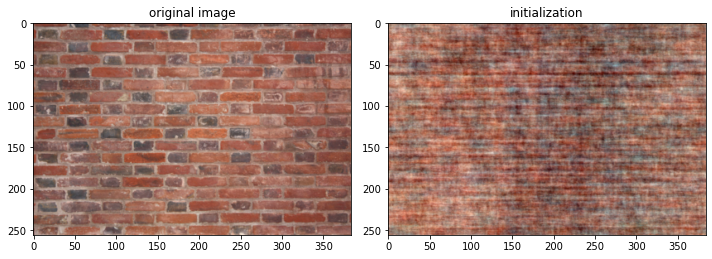

In [42]:
######################################################
### This section allows you to change target image ###
######################################################
# Select input image: ["bois.png", "briques.png", "mur.png", "tissu.png", "nuages.png","pebbles.jpg","wall1003.png"]
input_image_name = "briques.png"
img_size = 256

# Prepare texture data
target = prep_img(input_image_name, img_size).to(device)
######################################################

# set seed to reproduce examples
torch.manual_seed(123)

#init image with adsn from target image (normalized)
x = adsn(target)

# print images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
axes[0].imshow(to_pil(target))
axes[0].set_title('original image')
xrgb = denormalize(x).to('cpu').permute(1,2,0)
axes[1].imshow(xrgb)
axes[1].set_title('initialization')

fig.tight_layout()
plt.pause(0.05)




## Running Texture Synthesis

Finally, we must run code that performs the texture synthesis. 

For each iteration of the network, it is fed an updated input and computes new losses between target activations and synth activations (activations of the layers selected for the image that it is being optimized). 

We will run the backward methods of each loss module to dynamically compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

In [44]:
# mean spatial dimension tensor
def mean_Spatial (input: torch.Tensor):

    input_redim = input.squeeze(0)
    c,h,w = input_redim.size() 
    input_redim_view = input_redim.view(c, h*w)
    mean_input = torch.mean(input_redim_view, axis=1) 
    return mean_input   

Iteration: 0, loss: 4042.217285


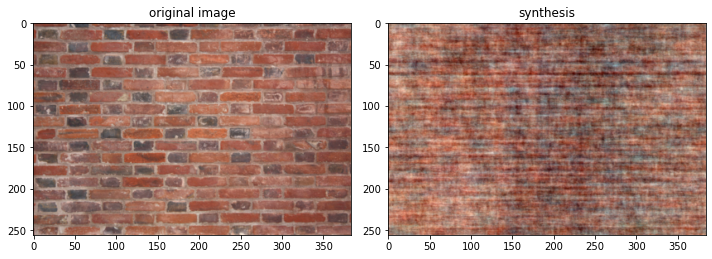

Iteration: 200, loss: 13643.308594


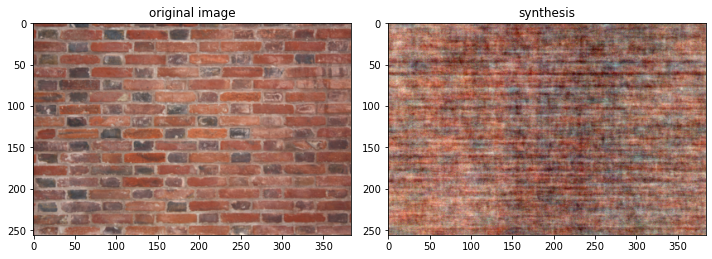

Iteration: 400, loss: 4334.131836


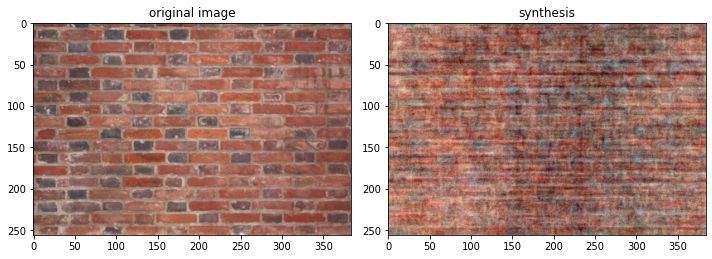

Iteration: 600, loss: -26614.656250


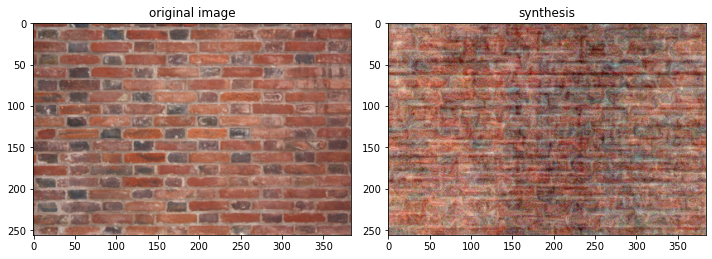

Iteration: 800, loss: -51078.414062


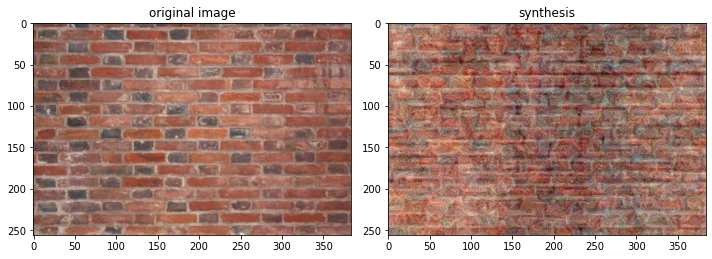

Iteration: 1000, loss: -59146.890625


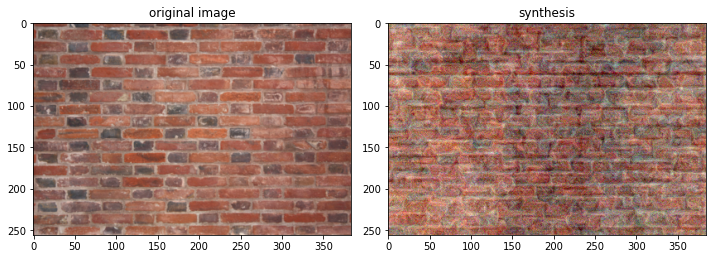

Iteration: 1200, loss: -56048.781250


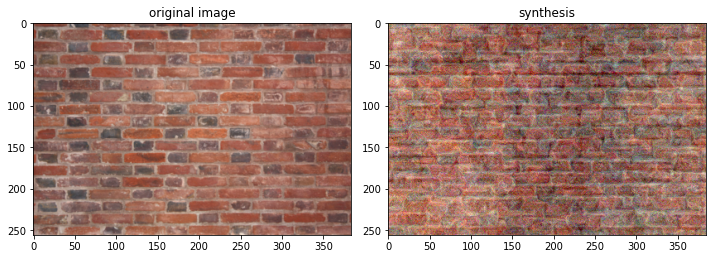

Iteration: 1400, loss: -48708.500000


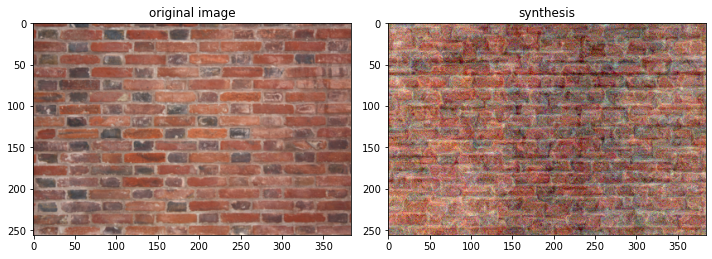

Iteration: 1600, loss: -40711.851562


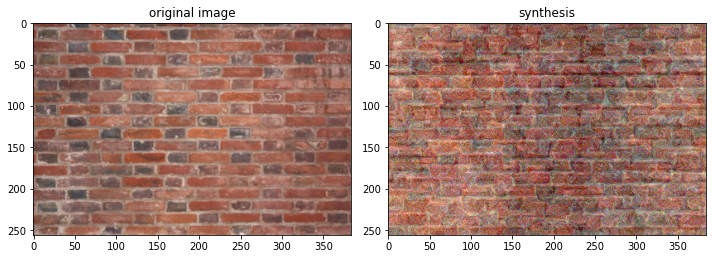

Iteration: 1800, loss: -33983.796875


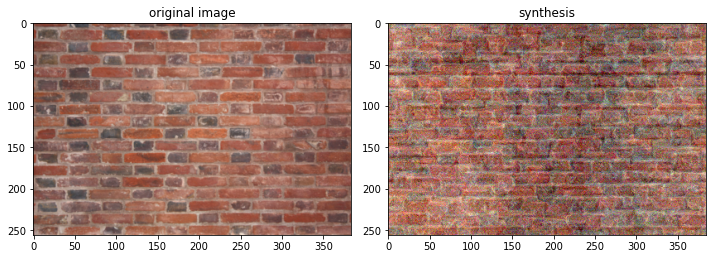

In [45]:
n_iters = 2000
log_every = n_iters//10

# steps and epsilon
gamma = 10e-3
delta = 10e-5
epsilon = 0.1

# Calculate just once means spatial of activations with target image. 
cnn(target)
meansTargetOutputs = [mean_Spatial(outputs[key]) for key in layers] 

# initialize weights (Theta)
theta = [torch.zeros_like(meansTargetOutputs[i]) for i in range(len(meansTargetOutputs))]

for iter in range(n_iters):
     
        x.requires_grad=True

        # Forward pass using x. Get activations of selected layers for image x (outputs).
        cnn(x)
        x_outputs = [outputs[key] for key in layers] 

        V = 0
     
        # optimize image
        if (iter % 2 == 0):
            # Compute loss V
            J = (epsilon /2) * x.pow(2).sum()
            V = J
            for i in range(len(layers)):
                V = V + torch.dot(theta[i], mean_Spatial(x_outputs[i]))

            V.backward()
       
            # update image
            with torch.no_grad():
                z_rand = torch.randn_like(x) 
                x = x - delta * x.grad + math.sqrt(2 * delta) * z_rand

            x.requires_grad=True

        # optimize parameters 
        else: 
            with torch.no_grad():
                for i in range(len(layers)):
                    theta[i] = theta[i] + gamma * torch.sub(mean_Spatial(x_outputs[i]), meansTargetOutputs[i])
            
        # Display results: print Loss value and show image
        if (iter % log_every == 0):
            print('Iteration: %d, loss: %f'%(iter, V.item()))
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
            axes[0].imshow(to_pil(target))
            axes[0].set_title('original image')
            axes[1].imshow(to_pil(x))
            axes[1].set_title('synthesis')
            fig.tight_layout()
            plt.pause(0.05)